# EDMDDL Tests on Duffing Oscillator

In [1]:

import sys
sys.path.append('..')
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define ODE
ode = pkdl.DuffingOscillator()

# Define flow map
dt = 1e-3
t_step = 0.25
flowmap = pkdl.ForwardEuler(t_step, dt)

# Generate data set
n_traj = 1000
traj_len = 10
x_min = -2
x_max = 2
seed_x = 11
param = torch.tensor([[0.5, -1.0, 1.0]]).detach()
dataset = pkdl.ODEDataSet(ode, flowmap)
dataset.generate_data(n_traj, traj_len, x_min, x_max, param, seed_x)

# build dictionary
dim_output = 22
dim_nontrain = 3
hidden_layer_sizes = [100, 100, 100]
nontrain_func = lambda x: torch.cat([torch.ones((x.size(0), 1)), x], dim=1)
network = pkdl.FullConnResNet(ode.dim, dim_output - dim_nontrain, hidden_layer_sizes)
dictionary = pkdl.TrainableDictionary(network, nontrain_func, ode.dim, dim_output, dim_nontrain)

# build solver
n_epochs = 300
batch_size = 1000
reg = 0.1
reg_final = 0.01
tol = 1e-9
lr = 1e-4
solver = pkdl.EDMDDLSolver(dictionary, reg, reg_final)
K = solver.solve(dataset, n_epochs, batch_size, tol, lr)

CUDA is available. GPU is being used.


Training: 100%|██████████| 300/300 [01:03<00:00,  4.75it/s, loss=2.72e-07]


## Plot

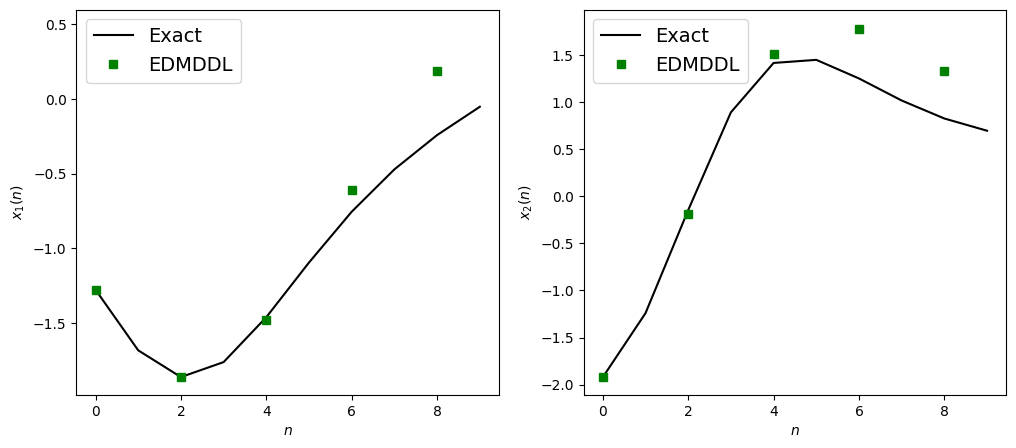

In [2]:

# predict
dataset_predict = pkdl.ODEDataSet(ode, flowmap)
dataset_predict.generate_data(1, traj_len, x_min, x_max, param)
x0 = torch.unsqueeze(dataset_predict.data_x[0], dim=0)
p = K.predict(x0, dictionary, dim_nontrain, traj_len)
x_est_traj = p[0, :, :].detach().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  
t_grid = np.arange(0, traj_len)
x_traj = dataset_predict.data_x
ax1.plot(t_grid, x_traj[:,0], 'k-', label='Exact', markevery=2)
ax1.plot(t_grid, x_est_traj[:,1], 'gs', label='EDMDDL', markevery=2)

ax2.plot(t_grid, x_traj[:,1], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, x_est_traj[:,2], 'gs', label='EDMDDL', markevery=2)

ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})